Start with Importing important Libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error


In [ ]:

# First step is to Load dataset day.csv
df = pd.read_csv("day.csv")
print("Data loaded:", df.shape)


Data loaded: (730, 16)


In [20]:

# Dropping irrelevant columns from dataset
df.drop(columns=[c for c in ['instant', 'dteday', 'casual', 'registered'] if c in df.columns], inplace=True, errors='ignore')

# Mapping categorical variables with binary values
if 'season' in df.columns:
    df['season'] = df['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
if 'weathersit' in df.columns:
    df['weathersit'] = df['weathersit'].map({1:'clear', 2:'mist', 3:'light_rain', 4:'heavy_rain'})


Performing EDA

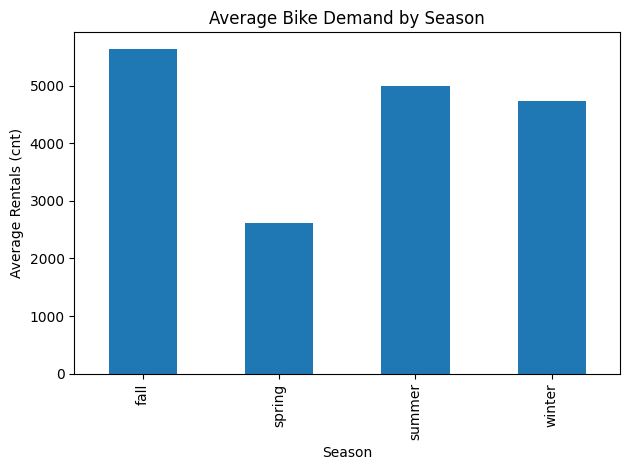

In [21]:

df.groupby("season")["cnt"].mean().plot(kind="bar")
plt.title("Average Bike Demand by Season")
plt.xlabel("Season")
plt.ylabel("Average Rentals (cnt)")
plt.tight_layout()
plt.show()


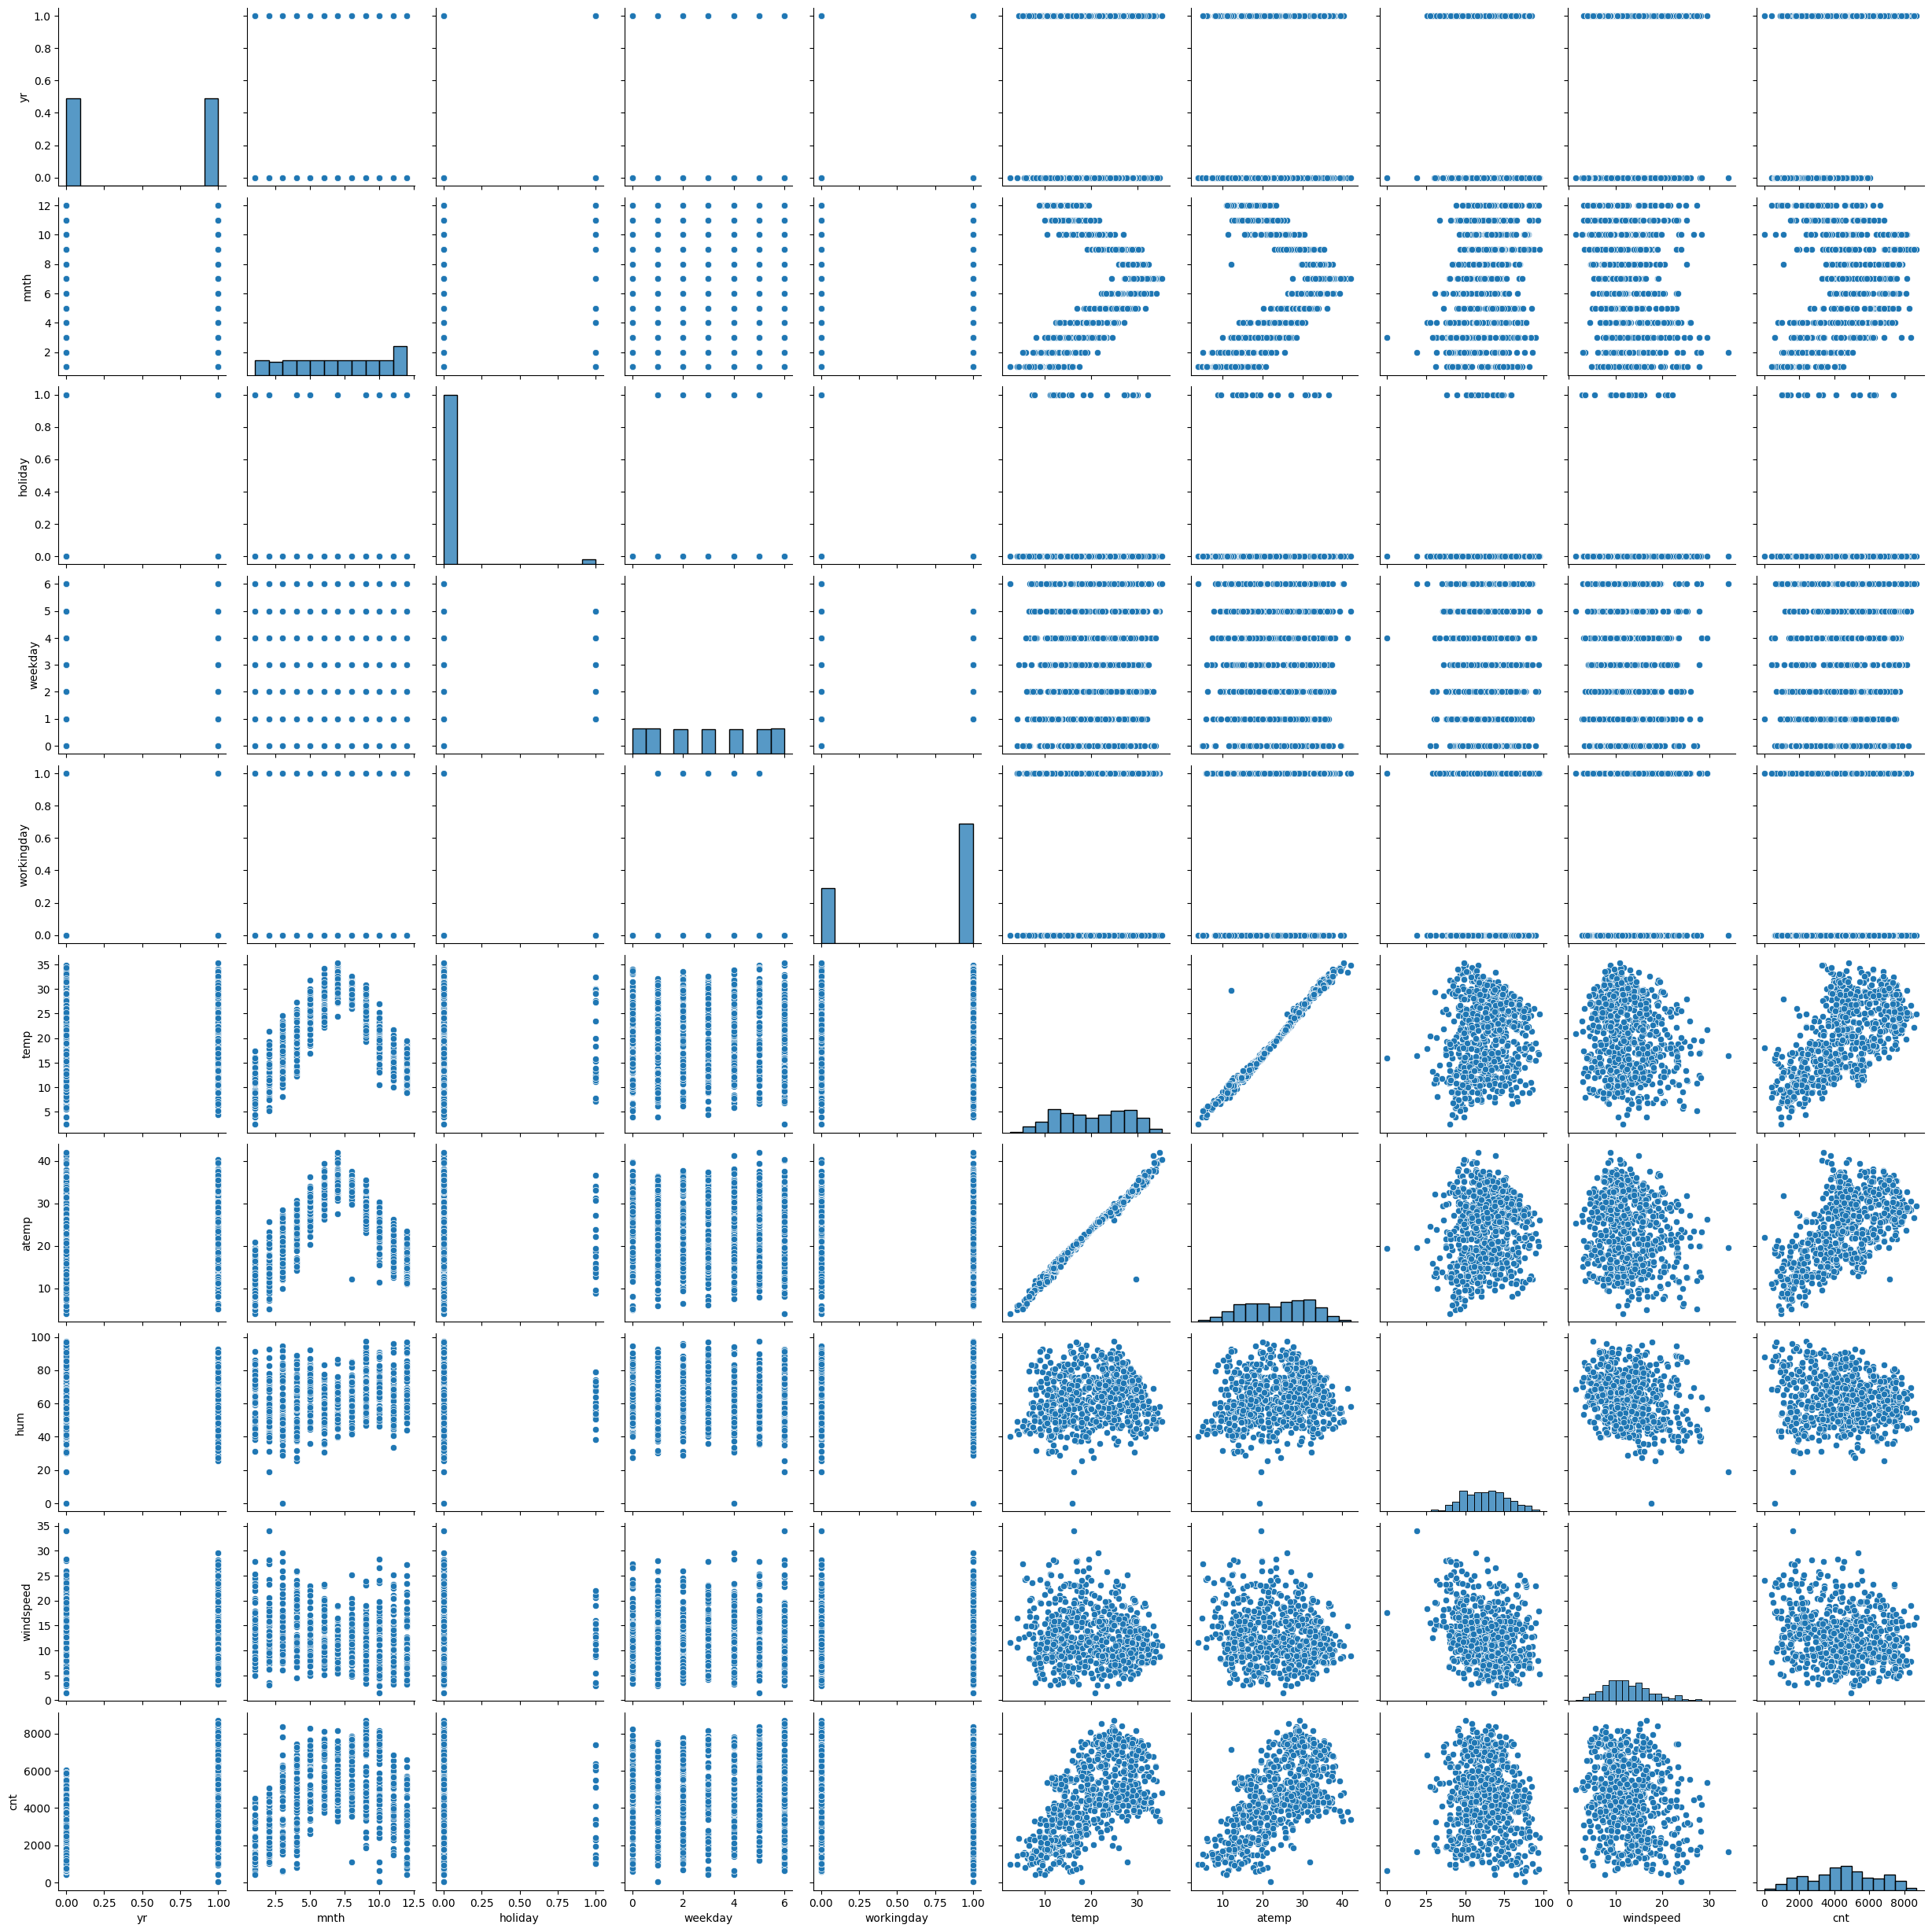

---------------
cnt           1.000000
atemp         0.630685
temp          0.627044
yr            0.569728
mnth          0.278191
weekday       0.067534
workingday    0.062542
holiday      -0.068764
hum          -0.098543
windspeed    -0.235132
Name: cnt, dtype: float64
----------------------------


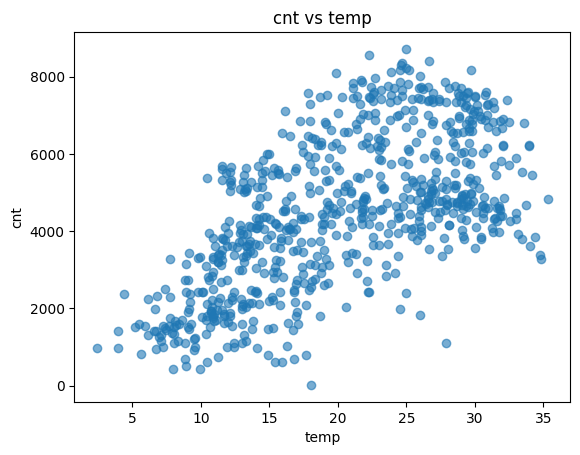

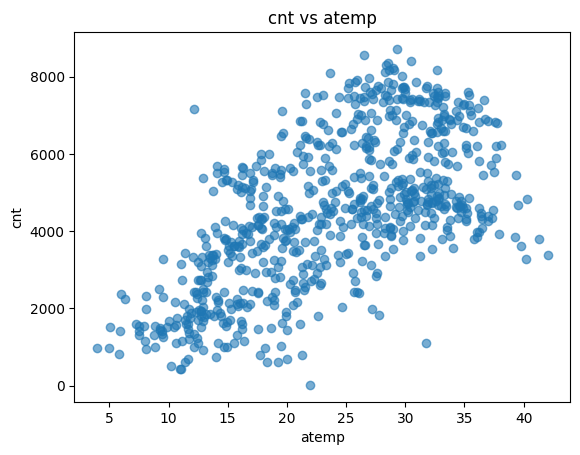

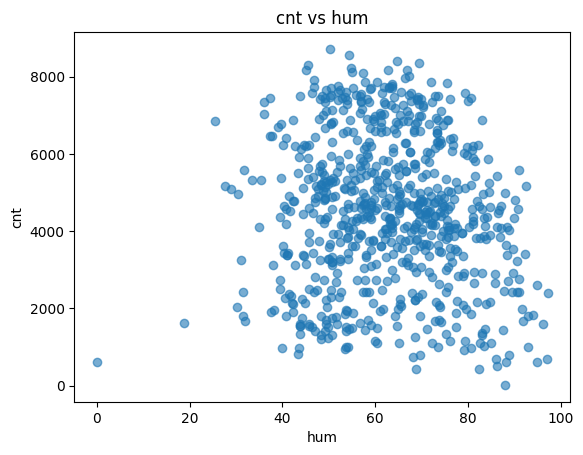

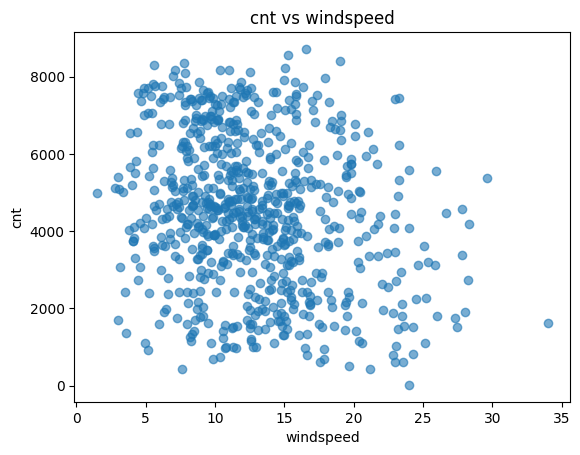

In [22]:

num_cols = df.select_dtypes(include=['int64','float64'])
sns.pairplot(num_cols)
plt.show()

print("---------------")
print(df[num_cols.columns].corr()['cnt'].sort_values(ascending=False))
print("----------------------------")

cols = ['temp','atemp','hum','windspeed','cnt']
existing = [c for c in cols if c in df.columns]
if len(existing) >= 2:
    for c in existing[:-1]:
        plt.figure()
        plt.scatter(df[c], df['cnt'], alpha=0.6)
        plt.title(f'cnt vs {c}')
        plt.xlabel(c)
        plt.ylabel('cnt')
        plt.show()
else:
    print('Not enough numeric columns for pairwise scatter plots.')
    


Next step is to define target and features

In [23]:

X = df.drop('cnt', axis=1)
y = df['cnt']

# Dummies categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)


# 4. Convert everything to numeric and clean up
X = X.apply(pd.to_numeric, errors='coerce')

# Check for any non-numeric columns
non_numeric = X.columns[~X.dtypes.apply(np.issubdtype, args=(np.number,))]
if len(non_numeric) > 0:
    print("Non-numeric columns caught and dropped :", non_numeric.tolist())
    X = X.drop(columns=non_numeric)


Non-numeric columns caught and dropped : ['season_spring', 'season_summer', 'season_winter', 'weathersit_light_rain', 'weathersit_mist']


Dropping Missing/Infinite Values

In [24]:

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.dropna(inplace=True)
y = y.loc[X.index]


In [25]:

# Lets look at the shape of dataframe again
print("After cleanup — X:", X.shape, " | y:", y.shape)
print("All numeric:", X.dtypes.apply(lambda x: np.issubdtype(x, np.number)).all())

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


After cleanup — X: (730, 9)  | y: (730,)
All numeric: True


Perform Scaling - Scaling numeric features to make the model more reliable

In [26]:
scaler = StandardScaler()
num_cols = ['temp', 'atemp', 'hum', 'windspeed']
for col in num_cols:
    if col in X_train.columns:
        X_train[col] = scaler.fit_transform(X_train[[col]])
        X_test[col] = scaler.transform(X_test[[col]])

# Creating custom functions that can be reused
def compute_vif(X_df):
    Xc = sm.add_constant(X_df)   # this adds constant term to the feature set and calculate vif  for each feature
    vif = pd.DataFrame({
        "feature": Xc.columns,
        "VIF": [variance_inflation_factor(Xc.values, i) for i in range(Xc.shape[1])]
    })
    return vif.sort_values("VIF", ascending=False)

# the below function removes insignificant features (based on the p-values) that donot contribute to the model
# Setting the p-value threshold as 0.05 also called significance level (sl)
def backward_elimination(X, y, sl=0.05):
    X_work = X.copy()
    while True:
        Xc = sm.add_constant(X_work)
        model = sm.OLS(y, Xc).fit()
        pvals = model.pvalues.drop('const', errors='ignore')
        max_p = pvals.max()
        if max_p > sl:
            drop_feat = pvals.idxmax()
            print(f"Dropping '{drop_feat}' (p={max_p:.4f})")
            X_work = X_work.drop(columns=[drop_feat])
        else:
            break
    final_model = sm.OLS(y, sm.add_constant(X_work)).fit()
    return final_model, X_work.columns


Running OLS Regression

Dropping 'workingday' (p=0.1702)
Dropping 'temp' (p=0.1138)

Final model summary:
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     215.5
Date:                Sun, 16 Nov 2025   Prob (F-statistic):          5.95e-147
Time:                        17:02:14   Log-Likelihood:                -4238.5
No. Observations:                 511   AIC:                             8493.
Df Residuals:                     503   BIC:                             8527.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------

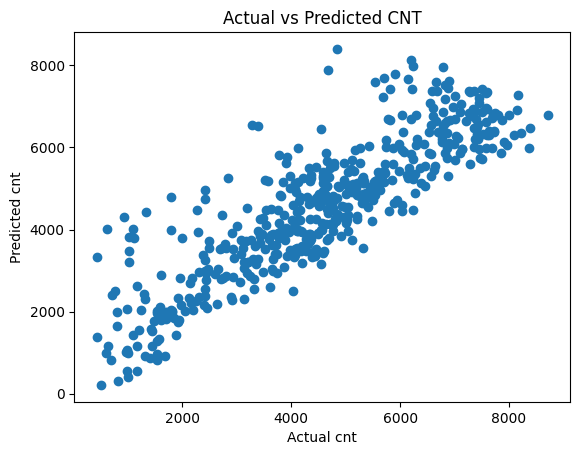


Model Performance is as:
Train R²: 0.750
Test R²:  0.779
Test RMSE: 904.663


In [27]:

# Running OLS and computing VIF
vif_table = compute_vif(X_train)


final_model, final_features = backward_elimination(X_train, y_train)
print("\nFinal model summary:")
print(final_model.summary())

#Evaluating the model -----
X_test_final = sm.add_constant(X_test[final_features], has_constant='add')
y_pred = final_model.predict(X_test_final)

X_train_final=sm.add_constant(X_train[final_features],has_constant='add')
y_train_pred=final_model.predict(X_train_final)

plt.scatter(y_train, y_train_pred)
plt.xlabel("Actual cnt")
plt.ylabel("Predicted cnt")
plt.title("Actual vs Predicted CNT")
plt.show()

print("\nModel Performance is as:")
print(f"Train R²: {final_model.rsquared:.3f}")
print(f"Test R²:  {r2_score(y_test, y_pred):.3f}")
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.3f}")
